Goal: customer segment based on order_hour_of_day and order_dow

Method: NMF

Include: 
* customer segment based on order_hour_of_day 
* customer segment based on order_dow
* customer segment based on department(pca + svd) 

In [2]:
import pandas as pd
import numpy as np

from sklearn.decomposition import NMF , ProjectedGradientNMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import plotly.plotly as py

import graphlab

import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

from sklearn.decomposition import LatentDirichletAllocation as LDA

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1519774579.log


This non-commercial license of GraphLab Create for academic use is assigned to my102@duke.edu and will expire on May 31, 2018.


In [3]:
graphlab.canvas.set_target('ipynb')

In [4]:
def NMF_model(df, n):
    nmf = NMF(init='nndsvd', max_iter=200,\
            n_components=n, nls_max_iter=2000, random_state=0,\
            sparseness='components', solver = 'cd', alpha = 0.1, l1_ratio = 1)
    
    model = nmf.fit(df)
    
    W = model.fit_transform(df)
    H = model.components_

    return W, H, model.reconstruction_err_


In [5]:
def clusterw_h(W, H, colnmae):
    clusterW = np.argmax(W, 1)
    clusterW = pd.DataFrame(clusterW).reset_index()
    clusterW.columns = ['user_id','factor']
    clusterW.user_id = clusterW.user_id+1
    
    clusterH = np.argmax(H, 1)
    clusterH = pd.DataFrame(clusterH).reset_index()
    clusterH.columns = ['factor', colnmae]
    
    return clusterW, clusterH

In [6]:
def get_group(df, col):
    grouped = df.groupby(col)
    group = {}
    prior_time = {}
    for index, number in enumerate(clusterH[col].values):
        group[index] = grouped.get_group(number)
        prior_time[index] = prior[prior['user_id'].isin(group[index]['user_id'])]
    return group, prior_time

In [7]:
def plot_cluster(df, x_column, y_column, title_name,xlabel,ylabel):
    x = df[x_column].values

    plt.bar(x,height = list(df[y_column].values), width = 0.8)
    plt.xticks(x,x)
    plt.xlabel(xlabel,fontsize = 14)
    plt.ylabel(ylabel,fontsize = 14)
    plt.title(title_name,fontsize = 20)
    plt.show()

In [8]:
prior_data_da = pd.read_csv('prior_data_da.csv')
prior = pd.read_csv('prior.csv')

In [8]:
prior.head()

,Unnamed: 0,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0,2539329,1,prior,1,2,8,NaN
1,1,2398795,1,prior,2,3,7,15.0
2,2,473747,1,prior,3,3,12,21.0
3,3,2254736,1,prior,4,4,7,29.0
4,4,431534,1,prior,5,4,15,28.0


## segment customer by order day

In [9]:
customer_orderday = pd.crosstab(prior['user_id'],prior['order_dow'], rownames=['user id'], colnames=['order day'])
customer_orderday.columns = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

In [10]:
customer_orderday.head(10)

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
user id,,,,,,,
1,0,3,2,2,3,0,0
2,0,5,5,2,1,1,0
3,6,2,1,3,0,0,0
4,0,0,0,0,2,2,1
5,1,1,0,2,0,0,0
6,0,0,1,0,1,1,0
7,6,5,2,4,0,2,1
8,0,1,0,0,0,1,1
9,1,1,0,0,0,1,0


In [ ]:
# orderday_transform =  CountVectorizer(dtype=float).fit_transform(customer_orderday)
# orderday_transform = normalize(orderday_transform)

In [11]:
orderday_transform = csr_matrix(customer_orderday)
#orderday_transform2 = normalize(orderday_transform2)

In [12]:
orderday_transform.shape

(206209, 7)

In [12]:
# NMF_model = NMF(init='nndsvd', max_iter=200,\
#             n_components=2, nls_max_iter=2000, random_state=0,\
#             sparseness='components', tol=0.0001,
#                solver = 'cd')
# NMF_model.fit(orderday_transform2)     

In [13]:
W_3, H_3, error_3 = NMF_model(orderday_transform, 4)

/Users/mengruiyin/anaconda/lib/python2.7/site-packages/sklearn/decomposition/nmf.py:997: DeprecationWarning:

Controlling regularization through the sparseness, beta and eta arguments is only available for 'pg' solver, which will be removed in release 0.19. Use another solver with L1 or L2 regularization instead.



In [14]:
W_3.shape

(206209, 4)

In [15]:
H_3.shape

(4, 7)

In [16]:
clusterW, clusterH = clusterw_h(W_3, H_3, 'day')

In [17]:
cluster_day = clusterW.merge(clusterH)

In [18]:
cluster_day.to_csv('cluster_day.csv')

In [19]:
group, prior_day = get_group(cluster_day, 'day')

In [20]:
#np.save('group.npy', group) 

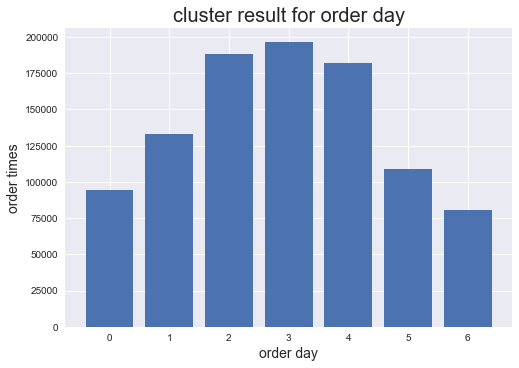

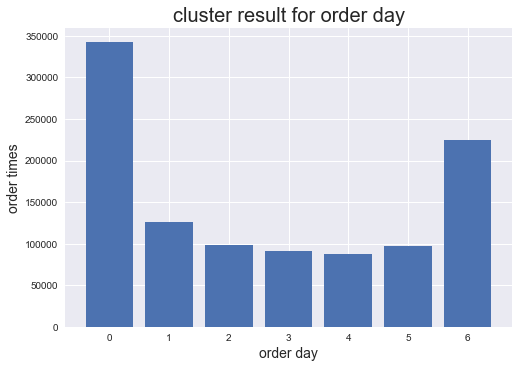

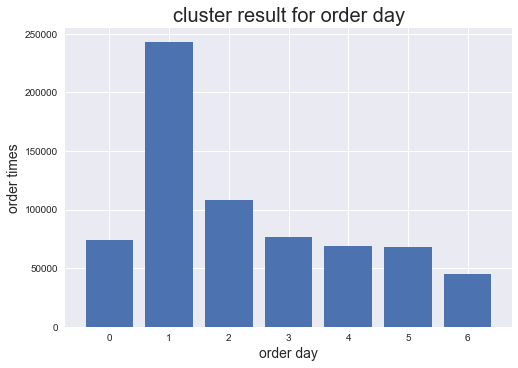

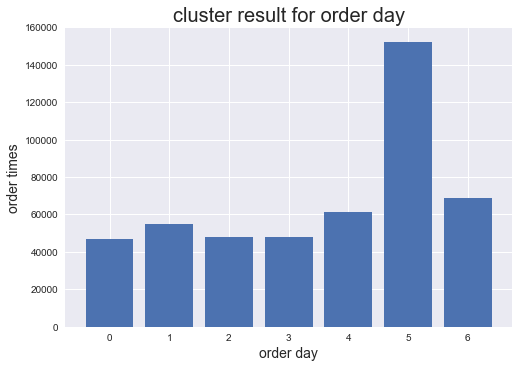

In [21]:
day_count = {}
for index in range(clusterH.shape[0]):
    #prior_time = prior[prior['user_id'].isin(group[index]['user_id'])]
    day_count[index] = pd.DataFrame(prior_day[index].groupby('order_dow', as_index = False)['order_id'].count())
    plot_cluster(day_count[index], 'order_dow', 'order_id', 'cluster result for order day','order day', 'order times')

In [60]:
group

{0:        user_id  factor  day
 0            1       0    3
 1            5       0    3
 2           20       0    3
 3           26       0    3
 4           27       0    3
 5           31       0    3
 6           32       0    3
 7           43       0    3
 8           47       0    3
 9           50       0    3
 10          51       0    3
 11          54       0    3
 12          57       0    3
 13          59       0    3
 14          69       0    3
 15          70       0    3
 16          71       0    3
 17          73       0    3
 18          76       0    3
 19          81       0    3
 20          83       0    3
 21          91       0    3
 22          96       0    3
 23          98       0    3
 24          99       0    3
 25         100       0    3
 26         103       0    3
 27         104       0    3
 28         120       0    3
 29         131       0    3
 ...        ...     ...  ...
 56910   206110       0    3
 56911   206113       0    3
 56912   20

In [ ]:
# grouped = cluster_time.groupby(['time'])
# group = {}
# for index, number in enumerate(clusterH.time.values):
#     group[index] = grouped.get_group(number)

In [ ]:
# def find_optimal_number(df, cluster_start, cluster_end):
    
#     cluster_range = range(cluster_start, cluster_end)
#     cluster_errors = []
    
#     for num_clusters in cluster_range:
#         nmf = NMF(init='nndsvd', max_iter=200,\
#             n_components=num_clusters, nls_max_iter=2000, random_state=0,\
#             sparseness='components', solver = 'cd', alpha = 0.1, l1_ratio = 1)
#         model = nmf.fit(df)
#         #W = model.fit_transform(df)
#         #H = model.components_
#         #product = np.dot(W,H)
#         #error = np.sum(np.array(df-product))**2
#         error = model.reconstruction_err_
#         cluster_errors.append(error)
#     clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
#     return clusters_df

In [ ]:
# cluster_error = find_optimal_number(orderday_transform,2, 8)

In [ ]:
# plt.figure(figsize=(12,6))
# plt.plot( cluster_error.num_clusters, cluster_error.cluster_errors, marker = "o" )
# plt.show()

## segment customer by order hour

In [23]:
customer_ordertime = pd.crosstab(prior['user_id'],prior['order_hour_of_day'], rownames=['user id'], colnames=['order hour'])

In [24]:
ordertime_transform = csr_matrix(customer_ordertime)

In [25]:
ordertime_transform.shape

(206209, 24)

In [26]:
# find_optimal_number(ordertime_transform, 10, 20)

In [40]:
W2_8, H2_8, error2_8 = NMF_model(ordertime_transform, 4)

/Users/mengruiyin/anaconda/lib/python2.7/site-packages/sklearn/decomposition/nmf.py:997: DeprecationWarning:

Controlling regularization through the sparseness, beta and eta arguments is only available for 'pg' solver, which will be removed in release 0.19. Use another solver with L1 or L2 regularization instead.



In [41]:
W2_8.shape

(206209, 4)

In [42]:
H2_8.shape

(4, 24)

In [43]:
error2_8

1837.5582751726338

In [44]:
clusterW, clusterH = clusterw_h(W2_8, H2_8, 'time')

In [45]:
clusterH

,factor,time
0,0,14
1,1,10
2,2,17
3,3,8


In [46]:
cluster_time = clusterW.merge(clusterH)

In [47]:
cluster_time

,user_id,factor,time
0,1,3,8
1,8,3,8
2,12,3,8
3,14,3,8
4,21,3,8
5,24,3,8
6,44,3,8
7,45,3,8
8,56,3,8
9,65,3,8


In [48]:
# cluster_time.to_csv('cluster_time.csv')

In [49]:
group, prior_time = get_group(cluster_time, 'time')

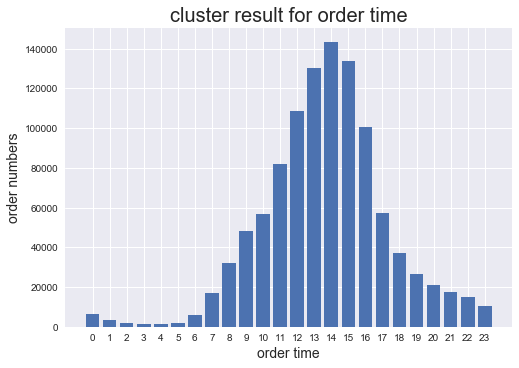

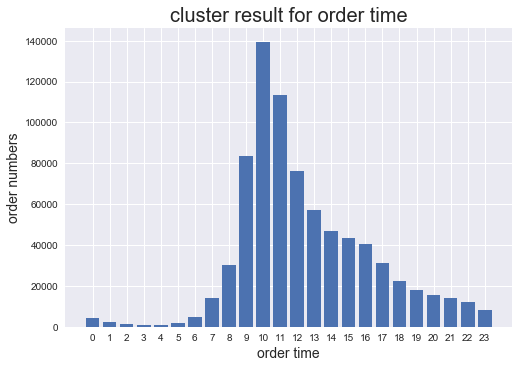

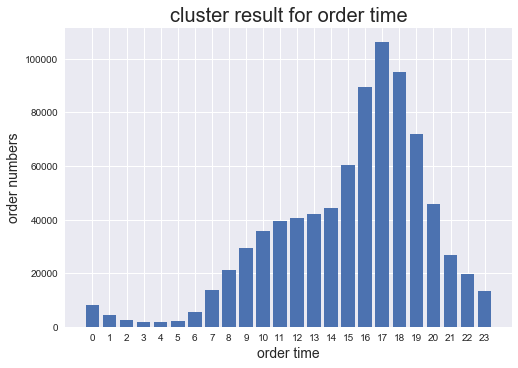

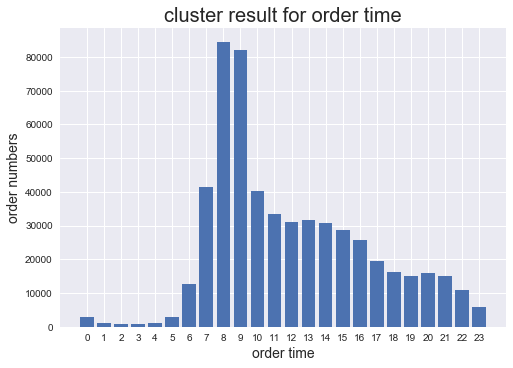

In [50]:
time_count = {}
for index in range(clusterH.shape[0]):
    #prior_time = prior[prior['user_id'].isin(group[index]['user_id'])]
    time_count[index] = pd.DataFrame(prior_time[index].groupby('order_hour_of_day', as_index = False)['order_id'].count())
    plot_cluster(time_count[index], 'order_hour_of_day', 'order_id', 'cluster result for order time','order time', 'order numbers')

## segment customer by department

In [337]:
customer_department = pd.crosstab(prior_data_da['user_id'],prior_data_da['department'], rownames=['user_id'], colnames=['department'])

### cluster method1: svd + k-means

In [339]:
svd_department = TruncatedSVD(n_components=2)
svd_department2 = svd_department.fit_transform(customer_department)

In [341]:
svd_department.explained_variance_ratio_

array([ 0.70727691,  0.11664377])

So these two components explain more than 80% of the orginal data. The first component explain 86% and the second component expalin 14%

In [347]:
svd_department_2D = pd.DataFrame(svd_department2)
svd_department_2D.index = customer_department.index
svd_department_2D.columns = ['PC1','PC2']
svd_department_2D.head()

,PC1,PC2
user_id,,
1,16.962063,19.797218
2,66.721852,32.380443
3,44.353542,-3.363004
4,3.319074,1.664083
5,19.983361,-5.359110


In [356]:
xaxis = pd.DataFrame(customer_department.corrwith(svd_department_2D['PC1'])).reset_index()
yaxis = pd.DataFrame(customer_department.corrwith(svd_department_2D['PC2'])).reset_index()
xaxis.columns = ['department','PC1']
yaxis.columns = ['department','PC2']
svd_plot = xaxis.merge(yaxis)

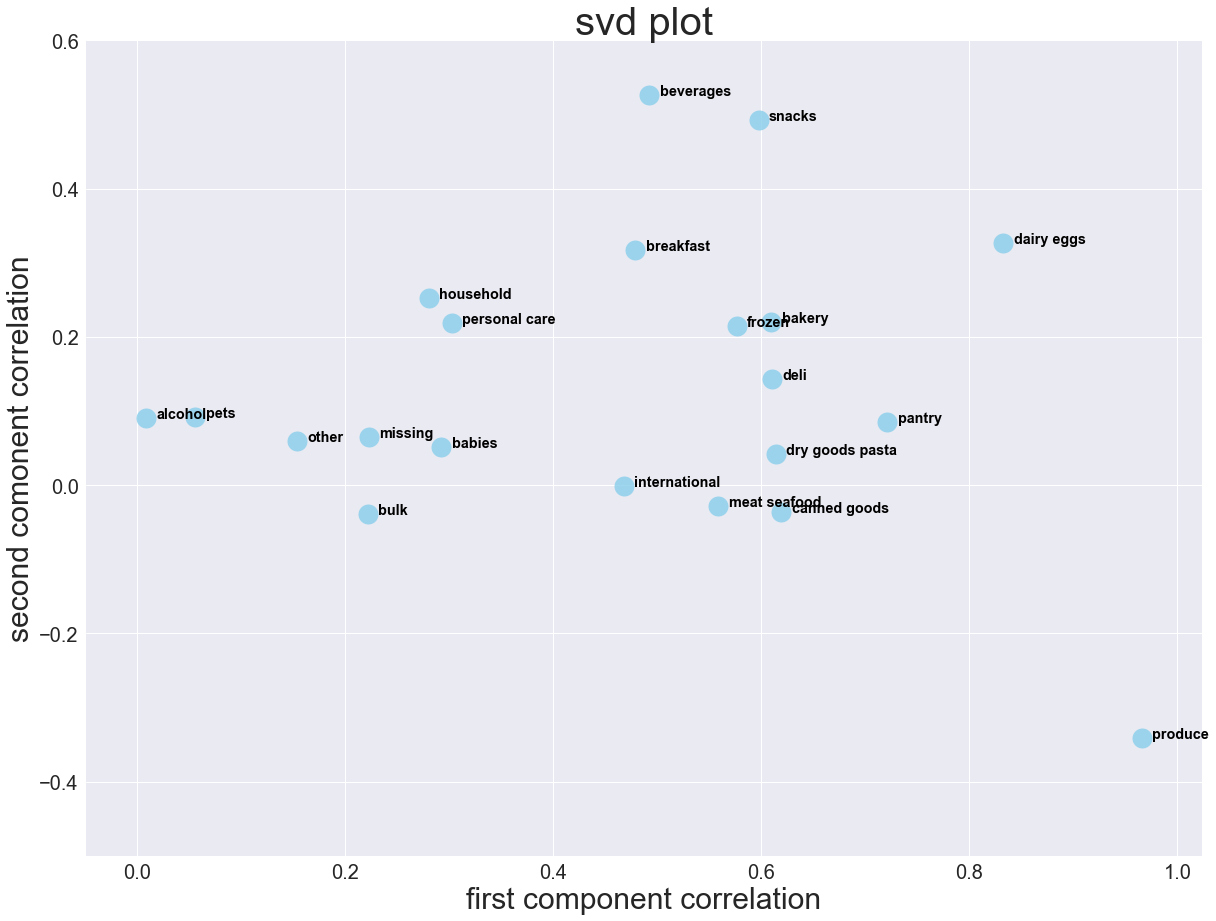

In [358]:
fig, ax = plt.subplots()

fig.set_size_inches(20, 15)

p1=sns.regplot(data=svd_plot , x="PC1", y="PC2", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
 
# add annotations one by one with a loop
for line in range(0,svd_plot.shape[0]):
     p1.text(svd_plot.PC1[line]+0.01,\
             svd_plot.PC2.values[line],\
             svd_plot.department.values[line], horizontalalignment='left',\
             size='large', color='black', weight='semibold')

p1.axes.set_title("svd plot",fontsize=40)
p1.set_xlabel("first component correlation",fontsize=30)
p1.set_ylabel("second comonent correlation",fontsize=30)
p1.tick_params(labelsize=20)
sns.plt.ylim(-0.5, 0.6)

sns.plt.show() 

The axis of the plot shows correlation between each department and the first comoponent after SVD and the y-axis of the plot shows correlation between each department and the second component. For example, department meat seafood has high correlation with first component. Points showed together represent these departments may be highly correlated. So meat seafood and canned goods might be highly correlated wiht each other.

In [ ]:
# cluster_department,svd_ratio,customer_department = customer_cluster(prior_data_da, prior_data_da['department'], ['department'])

In [348]:
cluster_range = range( 1, 20 )
cluster_errors = []
    
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters)
    clusters.fit(svd_department_2D)
    cluster_errors.append( clusters.inertia_ )

In [349]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

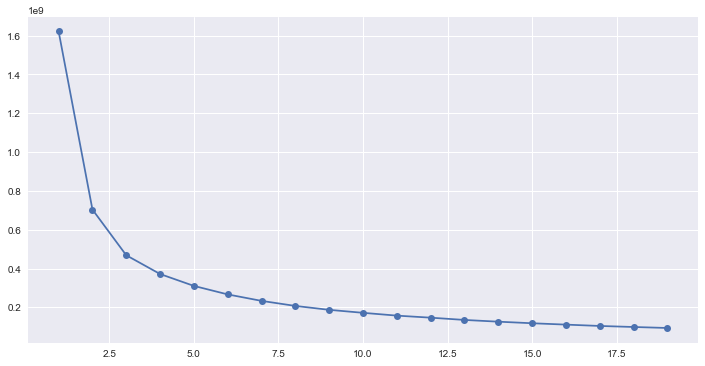

In [351]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.show()

To find the optimal number of cluster, I apply elbow method by calculating the SSE for every number of cluster. If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best. SSE tends to decrease as k increases. So we want to find a small number of k with low SSE. The elbow usually represents where we start to have diminishing returns by increasing k. So, here 4 could be the optimal number of cluster.

In [363]:
kmeans = KMeans(n_clusters=5, random_state=10)
clusters = kmeans.fit(svd_department_2D)

In [364]:
svd_department_2D['cluster'] = pd.Series(clusters.labels_, index=svd_department_2D.index)
customer_department['cluster'] = pd.Series(clusters.labels_, index=svd_department_2D.index)

In [372]:
grouped = customer_department.groupby('cluster')
table_count = pd.DataFrame(grouped['cluster'].count())
table_count

,cluster
cluster,
0,143156
1,12898
2,42451
3,3702
4,4002


In [382]:
department_pattern = {}
for i in range(table_count.shape[0]):
    customer_department = grouped.get_group(i).reset_index()
    department = prior_data_da[prior_data_da['user_id'].isin(customer_department['user_id'])]
    department_pattern[i] = pd.DataFrame(department.groupby('department', as_index=False)['order_id'].count()).\
                        sort_values('order_id', ascending = False)
        
    department_plot = graphlab.SFrame(department)
    department_plot['department'].show()

In [376]:
department_pattern[0]

,department,order_id
19,produce,2146173
7,dairy eggs,1402868
3,beverages,941742
20,snacks,872279
10,frozen,735469
16,pantry,583704
2,bakery,340838
6,canned goods,314984
11,household,311851
8,deli,294391


In [377]:
department_pattern[1]

,department,order_id
19,produce,2420428
7,dairy eggs,1013378
20,snacks,420076
10,frozen,358274
3,beverages,345653
16,pantry,344536
6,canned goods,214348
2,bakery,206112
8,deli,203026
9,dry goods pasta,164801


In [379]:
department_pattern[2]

,department,order_id
19,produce,2972729
7,dairy eggs,1719238
20,snacks,891124
3,beverages,832083
10,frozen,737924
16,pantry,602553
2,bakery,374382
6,canned goods,350179
8,deli,338470
9,dry goods pasta,282258
